In [1]:
!pip install opencv-python tensorflow



In [2]:
import os
import cv2
import json
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import matplotlib.pyplot as plt

print("All libraries imported successfully!")
print("TensorFlow Version:", tf.__version__)


All libraries imported successfully!
TensorFlow Version: 2.19.0


In [4]:
!unzip -q /content/Maize.zip -d /content/
print("Folder extracted successfully!")


Folder extracted successfully!


In [5]:
# Where your data is located after unzipping
DATA_DIR = '/content/Maize'

# Where to save the finished model and mapping file
MODEL_SAVE_PATH = '/content/maize_disease_model.h5'
MAPPING_SAVE_PATH = '/content/maize_class_indices.json'

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS_PHASE_1 = 15
EPOCHS_PHASE_2 = 20

print("Configuration set!")


Configuration set!


In [7]:
!ls /content/Maize


Healthy  Unhealthy


In [11]:
print("Loading images into memory...")

images = []
labels = []
class_names = []

# ================================
# SET YOUR LIMIT HERE
# ================================
MAX_IMAGES_PER_CLASS = 1100

def load_folder(folder_path, class_name):
    if not os.path.exists(folder_path): return
    if class_name not in class_names:
        class_names.append(class_name)
    class_idx = class_names.index(class_name)

    loaded_count = 0
    skipped_count = 0

    for filename in os.listdir(folder_path):
        # Stop loading if we hit the limit of 1100
        if loaded_count >= MAX_IMAGES_PER_CLASS:
            skipped_count += 1
            continue

        if filename.endswith(('.png', '.jpg', '.jpeg', '.JPG')):
            img_path = os.path.join(folder_path, filename)
            try:
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, IMG_SIZE)
                images.append(img)
                labels.append(class_idx)

                loaded_count += 1

            except Exception as e:
                print(f"Error reading {img_path}: {e}")

    print(f"[{class_name}] Loaded: {loaded_count} images (Skipped: {skipped_count} extra images)")

# Read the folders (USING CAPITALS)
load_folder(os.path.join(DATA_DIR, 'Healthy'), 'Healthy')
load_folder(os.path.join(DATA_DIR, 'Others'), 'Others')

unhealthy_dir = os.path.join(DATA_DIR, 'Unhealthy')
if os.path.exists(unhealthy_dir):
    for dir in os.listdir(unhealthy_dir):
        path = os.path.join(unhealthy_dir, dir)
        if os.path.isdir(path):
            load_folder(path, dir)

# Convert to Numpy Arrays
X = np.array(images)
y = np.array(labels)

print(f"\nSUCCESS: Loaded {len(X)} total images.")
print(f"Classes Found ({len(class_names)}): {class_names}")

Loading images into memory...
[Healthy] Loaded: 1100 images (Skipped: 62 extra images)
[Common_Rust] Loaded: 1100 images (Skipped: 206 extra images)
[Blight] Loaded: 1100 images (Skipped: 46 extra images)

SUCCESS: Loaded 3300 total images.
Classes Found (3): ['Healthy', 'Common_Rust', 'Blight']


In [12]:
print("Preprocessing images for ResNet50...")
X = tf.keras.applications.resnet.preprocess_input(X)

print("Splitting data into Training (80%) and Validation (20%)...")
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training Set: {len(X_train)} images")
print(f"Validation Set: {len(X_val)} images")

# Handle class imbalance automatically
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(weights))
print("Class Weights calculated!")


Preprocessing images for ResNet50...
Splitting data into Training (80%) and Validation (20%)...
Training Set: 2640 images
Validation Set: 660 images
Class Weights calculated!


In [13]:
print("Building the Transfer Learning Model...")

# Data augmentation block
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomTranslation(0.1, 0.1),
])

# Load Base Modela
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
base_model.trainable = False # Freeze base layers

# Create Top Model
inputs = keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(len(class_names), activation='softmax')(x)

model = keras.Model(inputs, outputs)

# Save rules
callbacks = [
    EarlyStopping(patience=8, restore_best_weights=True, monitor='val_accuracy'),
    ModelCheckpoint(MODEL_SAVE_PATH, save_best_only=True, monitor='val_accuracy'),
    ReduceLROnPlateau(factor=0.2, patience=3, monitor='val_loss')
]

model.summary()


Building the Transfer Learning Model...


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,113,027 (91.98 MB)

 Trainable params: 525,315 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [14]:
print("Starting PHASE 1: Training Custom Head Layers")

model.compile(
    optimizer=Adam(1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history1 = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS_PHASE_1,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    class_weight=class_weights
)


Starting PHASE 1: Training Custom Head Layers
Epoch 1/15
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.8608 - loss: 0.3728

83/83 ━━━━━━━━━━━━━━━━━━━━ 31s 234ms/step - accuracy: 0.8617 - loss: 0.3708 - val_accuracy: 0.9864 - val_loss: 0.0430 - learning_rate: 0.0010
Epoch 2/15
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9769 - loss: 0.0728

83/83 ━━━━━━━━━━━━━━━━━━━━ 14s 170ms/step - accuracy: 0.9769 - loss: 0.0729 - val_accuracy: 0.9879 - val_loss: 0.0434 - learning_rate: 0.0010
Epoch 3/15
83/83 ━━━━━━━━━━━━━━━━━━━━ 14s 164ms/step - accuracy: 0.9680 - loss: 0.0769 - val_accuracy: 0.9818 - val_loss: 0.0559 - learning_rate: 0.0010
Epoch 4/15
83/83 ━━━━━━━━━━━━━━━━━━━━ 14s 166ms/step - accuracy: 0.9714 - loss: 0.0714 - val_accuracy: 0.9848 - val_loss: 0.0508 - learning_rate: 0.0010
Epoch 5/15
83/83 ━━━━━━━━━━━━━━━━━━━━ 14s 169ms/step - accuracy: 0.9730 - loss: 0.0718 - val_accuracy: 0.9848 - val_loss: 0.0394 - learning_rate: 2.0000e-04
Epoch 6/15
83/83 ━━━━━━━━━━━━━━━━━━━━ 14s 172ms/step - accuracy: 0.9786 - loss: 0.0537 - val_accuracy: 0.9864 - val_loss: 0.0414 - learning_rate: 2.0000e-04
Epoch 7/15
83/83 ━━━━━━━━━━━━━━━━━━━━ 14s 171ms/step - accuracy: 0.9848 - loss: 0.0405 - val_accuracy: 0.9848 - val_loss: 0.0389 - learning_rate: 2.0000e-04
Epoch 8/15
83/83 ━━━━━━━━━━━━━━━━━━━━ 15s 175ms/step - accuracy: 0.9819 - loss: 0

In [15]:
print("Starting PHASE 2: Fine-Tuning Top 30 Layers")

# Unfreeze the base model
base_model.trainable = True

# Refreeze all layers except the top 30
for layer in base_model.layers[:-30]:
    layer.trainable = False

# Recompile with a MUCH LOWER learning rate
model.compile(
    optimizer=Adam(1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history2 = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS_PHASE_2,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    class_weight=class_weights
)


Starting PHASE 2: Fine-Tuning Top 30 Layers
Epoch 1/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.9433 - loss: 0.1530

83/83 ━━━━━━━━━━━━━━━━━━━━ 39s 319ms/step - accuracy: 0.9435 - loss: 0.1525 - val_accuracy: 0.9894 - val_loss: 0.0460 - learning_rate: 1.0000e-05
Epoch 2/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 18s 221ms/step - accuracy: 0.9712 - loss: 0.0829 - val_accuracy: 0.9894 - val_loss: 0.0420 - learning_rate: 1.0000e-05
Epoch 3/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 19s 225ms/step - accuracy: 0.9710 - loss: 0.0656 - val_accuracy: 0.9879 - val_loss: 0.0400 - learning_rate: 1.0000e-05
Epoch 4/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 19s 226ms/step - accuracy: 0.9769 - loss: 0.0564 - val_accuracy: 0.9864 - val_loss: 0.0388 - learning_rate: 1.0000e-05
Epoch 5/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 19s 229ms/step - accuracy: 0.9835 - loss: 0.0399 - val_accuracy: 0.9864 - val_loss: 0.0354 - learning_rate: 1.0000e-05
Epoch 6/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 19s 230ms/step - accuracy: 0.9883 - loss: 0.0374 - val_accuracy: 0.9879 - val_loss: 0.0330 - learning_rate: 1.0000e-05
Epoch 7/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 19s 229ms/step - accuracy: 0.98

83/83 ━━━━━━━━━━━━━━━━━━━━ 24s 289ms/step - accuracy: 0.9889 - loss: 0.0452 - val_accuracy: 0.9939 - val_loss: 0.0262 - learning_rate: 1.0000e-05
Epoch 10/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 19s 229ms/step - accuracy: 0.9882 - loss: 0.0362 - val_accuracy: 0.9924 - val_loss: 0.0253 - learning_rate: 1.0000e-05
Epoch 11/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 19s 231ms/step - accuracy: 0.9848 - loss: 0.0401 - val_accuracy: 0.9924 - val_loss: 0.0265 - learning_rate: 1.0000e-05
Epoch 12/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 19s 227ms/step - accuracy: 0.9883 - loss: 0.0306 - val_accuracy: 0.9894 - val_loss: 0.0256 - learning_rate: 1.0000e-05
Epoch 13/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 19s 229ms/step - accuracy: 0.9904 - loss: 0.0205 - val_accuracy: 0.9909 - val_loss: 0.0258 - learning_rate: 1.0000e-05
Epoch 14/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 19s 228ms/step - accuracy: 0.9867 - loss: 0.0278 - val_accuracy: 0.9909 - val_loss: 0.0262 - learning_rate: 2.0000e-06
Epoch 15/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 19s 229ms/step - accuracy


--- TRAINING COMPLETE ---
Model saved to: /content/maize_disease_model.h5
Mapping saved to: /content/maize_class_indices.json
Your App Classes: {0: 'Healthy', 1: 'Common_Rust', 2: 'Blight'}


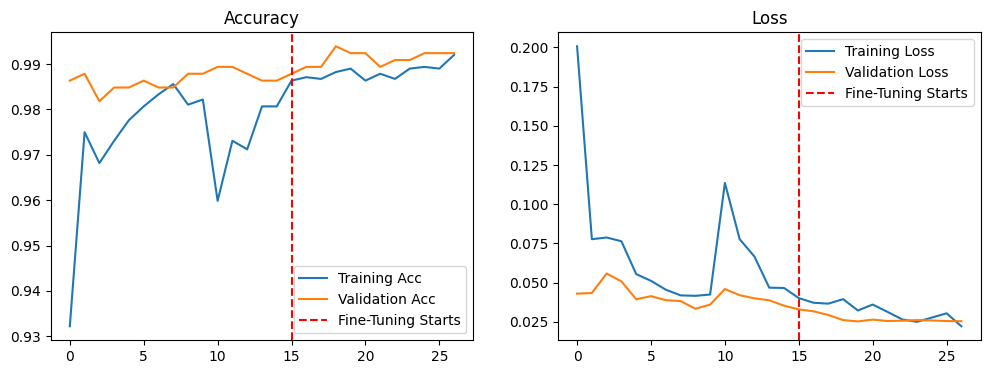

In [16]:
# Save the mapping file so your Flask app knows which index is which disease
class_mapping = {name: int(idx) for idx, name in enumerate(class_names)}
class_mapping_inverted = {int(idx): name for idx, name in enumerate(class_names)}

with open(MAPPING_SAVE_PATH, 'w') as f:
    json.dump(class_mapping, f)

print("\n--- TRAINING COMPLETE ---")
print(f"Model saved to: {MODEL_SAVE_PATH}")
print(f"Mapping saved to: {MAPPING_SAVE_PATH}")
print(f"Your App Classes: {class_mapping_inverted}")

# Plotting
acc = history1.history['accuracy'] + history2.history['accuracy']
val_acc = history1.history['val_accuracy'] + history2.history['val_accuracy']
loss = history1.history['loss'] + history2.history['loss']
val_loss = history1.history['val_loss'] + history2.history['val_loss']

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Acc')
plt.plot(val_acc, label='Validation Acc')
plt.axvline(x=EPOCHS_PHASE_1, color='red', linestyle='--', label='Fine-Tuning Starts')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.axvline(x=EPOCHS_PHASE_1, color='red', linestyle='--', label='Fine-Tuning Starts')
plt.legend()
plt.title('Loss')
plt.show()
